# CS269Q Tomography Debugger Project
State tomography involves measuring a quantum state repeatedly in the bases given by `itertools.product(['X', 'Y', 'Z], repeat=n_qubits)`. From these measurements, we can reconstruct a density matrix $\rho$. In this project we set out to create a debugging tool to perform state tomography. This project had two parts. The first was constructing a debuggin interface. We decided that our debugger would take the form of a function that could be called on a program and a list of qubits, and would then run tomography algorithms and output a density matrix. The second was choosing an appropriate advanced algorithm to perform state tomography. Since both linear inversion and MLE had already been implemented in the forest benchmarking tomography file (and since Bayesian estimates are apparently "formidable" for quantum states!), we decided to go with matrix completion/compressed sensing methods.

# Relevant Papers & Resources:

[Final Project Instructions](https://cs269q.stanford.edu/hw_and_proj/final_project.pdf)

[Ultra jank state tomography from lecture 6](https://cs269q.stanford.edu/lectures/lecture6.pdf)

[Quantum state tomography via compressed sensing](https://arxiv.org/pdf/0909.3304.pdf)

[NMR Techniques for Quantum Control and Computation](https://arxiv.org/pdf/quant-ph/0404064.pdf)

[Efficient quantum state tomography](https://www.nature.com/articles/ncomms1147.pdf)

[Quantum Tomography via Compressed Sensing: Error Bounds, Sample Complexity, and Efficient Estimators](https://arxiv.org/pdf/1205.2300.pdf)

[Quantum Tomography Wikipedia](https://en.wikipedia.org/wiki/Quantum_tomography#Linear_inversion)

[Forest Benchmarking tomograph.py](https://github.com/rigetti/forest-benchmarking/blob/master/forest/benchmarking/tomography.py)

[PyQuil operator-estimation.py](https://github.com/rigetti/pyquil/blob/master/pyquil/operator_estimation.py)

[Initialization and characterization of open quantum systems](https://uwspace.uwaterloo.ca/bitstream/handle/10012/9557/wood_christopher.pdf?sequence=3&isAllowed=y) (section 3.4)


## TO DO:

<input type="checkbox"> Get basic debugging function working with linear inversion

<input type="checkbox"> Make sure we have the most recent version of forest sdk - seems like files on github are different from the sdk we have!

<input type="checkbox"> Program the compressed sensing algorithm from [Quantum state tomography via compressed sensing](https://arxiv.org/pdf/0909.3304.pdf)

<input type="checkbox"> Decide if we want to program a second tomography algorithm

<input type="checkbox"> Figure out exactly how the debugger will work! Will it just be a function?

<input type="checkbox"> Profile the characteristics of our tomography debugger when faced with noise!

<input type="checkbox"> Change the debugger class to take a qc as an input? Then it can run any program that is given to it on a qvm or a qpu (which is desired functionality!)

<input type="checkbox"> Write final report

In [1]:
import numpy as np
import imp
from pyquil import Program, get_qc
from pyquil.gates import *
from forest.benchmarking.tomography import *
from pyquil.operator_estimation import *
from forest.benchmarking.compilation import basic_compile
from scipy.optimize import minimize
import random

from typing import Union, List

from pyquil.gate_matrices import SWAP, QUANTUM_GATES, STATES
from pyquil.operator_estimation import TensorProductState
from pyquil.paulis import PauliSum, PauliTerm
from pyquil.quilbase import Gate

import cvxpy as cp

from pyquil.operator_estimation import TomographyExperiment as PyQuilTomographyExperiment

## Tomography Debugger Class
This class provides a single method which takes in a program and a list of qubit indices to tomographize and returns the corresponding density matrix.

In [47]:
class TomographyDebugger:
    def __init__(self):
        pass

    def run_tomography_function(self, t_type, m, results: List[ExperimentResult], qubits: List[int]):
        qubit_num = len(qubits)
        d = 2 ** qubit_num
        pauli_list = []
        expectation_list = []
        
        if t_type == 'compressed_sensing':
                                        
#             A = np.zeros((m,1))
#             scale_factor = np.sqrt(d / float(m))
        
            for i in range(m):
                #Convert the Pauli term into a tensor
                r = results[i]
                p_tensor = lifted_pauli(r.setting.out_operator, qubits)
                e = r.expectation
                #A[i] = e * scale_factor
                pauli_list.append(p_tensor)
                expectation_list.append(e)
            
#             print(A.shape)
#             print(A)
#             adj_A = (np.matrix(A)).getH()
#             print(adj_A)
            
#             def generate_A(x):
#                 mat = vec.reshape((d,d))
                
#                 for i in range(self.m):
#                     A[i] = np.trace(pauli_i.dot*(mat)) * scale_factor
#                 pauli_list.append(p_tensor)
#                 expectation_list.append(e)
            
#             def obj_func(vec):
#                 m = vec.reshape((d,d))
#                 return np.trace(np.sqrt(m.getH().dot(m)))
            
#             def con_dantzig(vec):
#                 val = 

            s = cp.Variable((d,d),complex = True)
        
            obj = cp.Minimize(cp.norm(s, 'nuc'))
            constraints = [cp.trace(s) == 1]
            
            for i in range(len(pauli_list)):
                trace_bool = cp.trace(cp.matmul(pauli_list[i], s)) - expectation_list[i] == 0
                constraints.append(trace_bool)

            # Form and solve problem.
            prob = cp.Problem(obj, constraints)
            prob.solve()
            rho = s.value

            return rho
        
        elif t_type == "linear_inv":
            return linear_inv_state_estimate(results=results, qubits=qubits)

    def tomographize(self, t_type, m, program: Program, qubits: List[int], num_shots=1000):
        #Generate experiments
        qubit_experiments = generate_state_tomography_experiment(program=program, qubits=qubits)
        
        exp_list = []
        #Experiment holds all 2^n possible pauli matrices for the given number of qubits
        #Now take m random pauli matrices as per the paper's advice
        if (m > len(qubit_experiments)):
            print("Cannot sample more Pauli matrices thatn d^2!")
            return None
        exp_list = random.sample(list(qubit_experiments), m)
        
        input_exp = PyQuilTomographyExperiment(settings=exp_list, program=program)
        
        #Group experiments if possible to minimize QPU runs
        #experiment = group_experiments(experiment)

        #NOTE: Change qvm depending on whether we are simulating qvm
        qc = get_qc('%dq-qvm' % len(qubits))
        qc.compiler.quil_to_native_quil = basic_compile

        results = list(measure_observables(qc=qc, tomo_experiment=input_exp, n_shots=num_shots))

        rho = self.run_tomography_function(t_type, m, results=results, qubits=qubits)
        return rho

## Construct a state with a `Program`
We'll construct a two-qubit graph state by Hadamarding all qubits and then applying a controlled-Z operation across edges of our graph. In the two-qubit case, there's only one edge. 

In [48]:
#More complex example!
# qubits = [0, 1, 5]

# program = Program()
# for qubit in qubits:
#     program += H(qubit)
# program += CZ(qubits[0], qubits[1])
# program += X(qubits[1])
# program += RX(-np.pi/2, qubits[2])
# program += RY(-np.pi/2, qubits[0])
# program += X(qubits[2])
# program += CNOT(qubits[2], qubits[0])
# program += CZ(qubits[1], qubits[0])
# program += H(qubits[2])

qubits = [0, 1]

program = Program()
for qubit in qubits:
    program += H(qubit)
program += CZ(qubits[0], qubits[1])
program += RY(-np.pi/2, qubits[0])
program += X(qubits[1])
program += CNOT(qubits[1], qubits[0])

print(program)

H 0
H 1
CZ 0 1
RY(-pi/2) 0
X 1
CNOT 1 0



## Run the tomography debugger and print output

In [49]:
import time

start_linear = time.time()
m = 10
debugger = TomographyDebugger()
rho_linear = debugger.tomographize("linear_inv", m, program, qubits)
end_linear = time.time() - start_linear

print("Linear tomography took %gs" % end_linear)
print("Recovered density matrix:\n")
print(rho_linear)

start_compressed = time.time()
rho_compressed = debugger.tomographize("compressed_sensing", m, program, qubits)
end_compressed = time.time() - start_compressed
print("Compressed tomography took %gs" % end_compressed)
print("Recovered density matrix:\n")
print(rho_compressed)

Linear tomography took 1.21971s
Recovered density matrix:

[[-2.50000000e-01+1.37945211e-17j -9.50000000e-03+9.00000000e-03j
   2.49800181e-16-2.00000000e-03j  5.50000000e-03-6.60648817e-17j]
 [-9.50000000e-03-9.00000000e-03j  2.50000000e-01+2.29908685e-17j
  -5.50000000e-03+6.60648817e-17j -5.00000000e-01+6.00000000e-03j]
 [ 2.49800181e-16+2.00000000e-03j -5.50000000e-03+6.77579718e-17j
  -2.50000000e-01+4.59817369e-18j  2.85000000e-02-5.00000000e-03j]
 [ 5.50000000e-03-7.59886186e-17j -5.00000000e-01-6.00000000e-03j
   2.85000000e-02+5.00000000e-03j  2.50000000e-01-4.59817369e-18j]]
Compressed tomography took 1.24477s
Recovered density matrix:

[[-0.00149984-3.28129797e-17j -0.00574692+7.99983233e-03j
   0.00108753+4.01471361e-05j  0.00581965+8.49985083e-03j]
 [-0.00574692-7.99983233e-03j  0.49350005+3.35312119e-16j
   0.00081975+1.50013657e-03j -0.49891209-8.64950427e-03j]
 [ 0.00108753-4.01471361e-05j  0.00081975-1.50013657e-03j
   0.00150021-1.69667718e-16j -0.00076973-8.00016081e

## Compare results to true output obtained using wavefunction simulator

In [50]:
from pyquil.api import WavefunctionSimulator
wf_sim = WavefunctionSimulator()
wf = wf_sim.wavefunction(program)
psi = wf.amplitudes

rho_true = np.outer(psi, psi.T.conj())
print(np.around(rho_true, decimals=3))

[[ 0. +0.j -0. -0.j  0. +0.j  0. +0.j]
 [-0. +0.j  0.5+0.j -0. +0.j -0.5+0.j]
 [ 0. +0.j -0. -0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -0.5-0.j  0. +0.j  0.5+0.j]]


## Visualize using Hinton plots

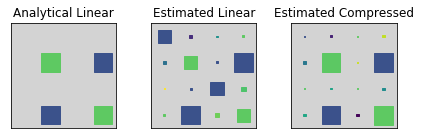

In [51]:
from matplotlib import pyplot as plt
from forest.benchmarking.plotting import hinton
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
hinton(rho_true, ax=ax1)
hinton(rho_linear, ax=ax2)
hinton(rho_compressed, ax=ax3)
ax1.set_title('Analytical Linear')
ax2.set_title('Estimated Linear')
ax3.set_title('Estimated Compressed')
fig.tight_layout()

## Calculate matrix norm between true and estimated rho

In [52]:
print("Linear norm:")
print(np.linalg.norm(rho_linear - rho_true))
print("Compressed norm:")
print(np.linalg.norm(rho_compressed - rho_true))

Linear norm:
0.5022131021787463
Compressed norm:
0.028012131769667735


## Plot graph of results for various measurement values

Analyzing performance of linear vs. compressed on program:
H 0
H 1
CZ 0 1
RY(-pi/2) 0
X 1
CNOT 1 0

Running iteration 1/16
Running iteration 2/16
Running iteration 3/16
Running iteration 4/16
Running iteration 5/16
Running iteration 6/16
Running iteration 7/16
Running iteration 8/16
Running iteration 9/16
Running iteration 10/16
Running iteration 11/16
Running iteration 12/16
Running iteration 13/16
Running iteration 14/16
Running iteration 15/16


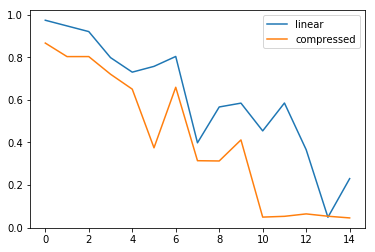

In [56]:
import matplotlib.pyplot as plt

max_pauli_num = 4 ** len(qubits)
num_trials = 5

linear_norms = []
compressed_norms = []

print("Analyzing performance of linear vs. compressed on program:")
print(program)

for i in range(1, max_pauli_num):
    print("Running iteration %d/%d" % (i, max_pauli_num))
    linear_norm_mean = 0.0
    compressed_norm_mean = 0.0
    for j in range(num_trials):
        rho_linear = debugger.tomographize("linear_inv", i, program, qubits)
        rho_compressed = debugger.tomographize("compressed_sensing", i, program, qubits)
        linear_norm_mean += np.linalg.norm(rho_linear - rho_true)
        compressed_norm_mean += np.linalg.norm(rho_compressed - rho_true)
    
    linear_norm_mean /= num_trials
    compressed_norm_mean /= num_trials
    
    linear_norms.append(linear_norm_mean)
    compressed_norms.append(compressed_norm_mean)

plt.plot(linear_norms, label='linear')
plt.plot(compressed_norms, label='compressed')
plt.legend()
plt.show()